In [7]:
import pandas as pd
import numpy as np

import nltk
from nltk import tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem.snowball import SnowballStemmer 
import pycountry
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
from matplotlib import cm
from gensim import corpora, models
from gensim.models.ldamodel import LdaModel
import math
import gensim

from wordcloud import WordCloud

from nltk.sentiment import SentimentIntensityAnalyzer



# The package nltk.stopwords need to be installed using this command nltk.download_shell()
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
from gensim.models.ldamodel import LdaModel
import matplotlib.pyplot as plt
%matplotlib inline
import math
import gensim

In [8]:
# Import original data
print("loading data from file")
emails = pd.read_csv('hillary-clinton-emails/Emails.csv')
emails = emails.set_index("Id")

loading data from file


# 1. Word Cloud

## Raw Corpus 

In [9]:
# We use the RawText
emailsRawText_df = pd.DataFrame(emails['RawText'])
emailsRawText_df.columns = ["Text"]

In [10]:
emailsRawText = ""
for i in range(1,emailsRawText_df.size+1):
    emailsRawText += emailsRawText_df.loc[i,"Text"]

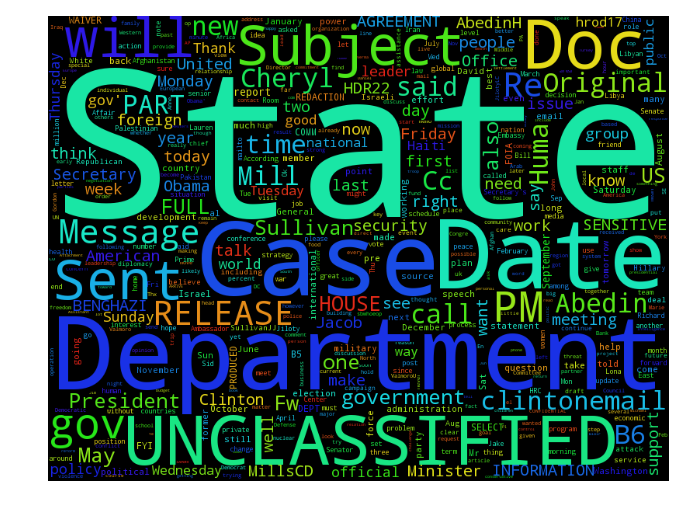

In [11]:
# Generate a word cloud image
wordcloud = WordCloud(width=800, height=600, max_words=500).generate(emailsRawText)

# Display the generated image:
plt.figure(figsize=(11,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Pre-Processed Corpus

In [12]:
# Functions used for Pre-processing:
def removeNoisyLines(sentences, noisy):
    filtered_sentences = ""
    for w in sentences:
        cond = True
        for n in noisy:
            if(w.startswith(n)):
                cond = False
                break
        if(cond):
            filtered_sentences += w + " "
    return filtered_sentences

def removePunctuation(text):
    #textWithoutPunct = ""
    textWithoutPunct = []
    for w in text:
        if not(len(w) == 1 and not w.isalpha()):
            #textWithoutPunct += w + " "
            textWithoutPunct.append(w)
    return textWithoutPunct

In [13]:
# Tokenization: (by line)
sentences = nltk.line_tokenize(emailsRawText)

In [14]:
# Remove Noisy Lines('UNCLASSIFIED', 'Subject:', 'From':, ...):
noisyLines = ['UNCLASSIFIED', 'U.S. Department of State', 'Case No.', 'Doc No.', 'Date:', 
              'STATE DEPT. - PRODUCED TO HOUSE SELECT BENGHAZI COMM.',
              'SUBJECT TO AGREEMENT ON SENSITIVE INFORMATION & REDACTIONS. NO FOIA WAIVER.', 
              'RELEASE IN']

noisyEmailLines = ['From', 'Sent', 'To', 'Subject', 'Cc', 'Fw', 'Re', 'Attachments', 'For']

noisy = noisyLines+noisyEmailLines

filtered_emailsText = removeNoisyLines(sentences, noisy)

In [15]:
# Tokenization: (by word)
words = nltk.word_tokenize(filtered_emailsText)

In [16]:
# StopWord Removal:
english_stopwords = stopwords.words('english')
filtered_emailsText = [w for w in words if not w.lower() in english_stopwords]

moreStopwords = ["'s", "``", "''", "Message", "Original", "would", "said", "--", "n't"]
filtered_emailsText = [w for w in filtered_emailsText if not w in moreStopwords]

In [17]:
# Remove Punctuation:
filtered_emailsText_withoutPunc = removePunctuation(filtered_emailsText)

In [18]:
# Stemming:
#stemmer = SnowballStemmer("english")
#stemmer = PorterStemmer()
#stems = [stemmer.stem(w) for w in filtered_emailsText_withoutPunc]

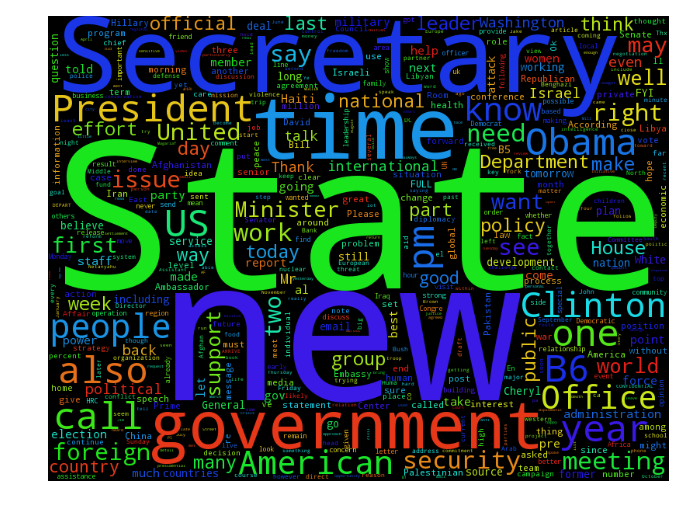

In [19]:
# Pre-Porcessed Corpus:
#emailsPreProcText = " ".join(stems)
emailsPreProcText = " ".join(filtered_emailsText_withoutPunc)

# Generate a word cloud image
wordcloudProc = WordCloud(width=800, height=600, max_words=500).generate(emailsPreProcText)

# Display the generated image:
plt.figure(figsize=(11,6))
plt.imshow(wordcloudProc)
plt.axis("off")
plt.show()

In [106]:
# Word Cloud Pros & Cons:
# The Pros: 1) useful visual representation of a text data
#           2) reveals the essential (quickly perceiving the most frequent terms)
#           3) can be helpful for pre-processing text 
#
# The Cons: We have noticed that the length of a word can make it look more or less important in the word cloud.
#           For instance in the second word cloud, the word "Secretary" looks more important than the word "B6" however
#           "B6" is more frequent in the corpus.

# 2. Mentions of world countries

In [20]:
def cleanEmail(email):
    # Tokenization: (by line)
    sentences = nltk.line_tokenize(email)
    filtered_emailsText = removeNoisyLines(sentences, noisy)
    # Tokenization: (by word)
    words = nltk.word_tokenize(filtered_emailsText)
    # StopWord Removal:
    filtered_emailsText = [w for w in words if not w.lower() in english_stopwords]
    moreStopwords = ["``", "''", "Message", "Original", "would", "said", "--"]
    filtered_emailsText = [w for w in filtered_emailsText if not w in moreStopwords]
    emailsPreProcText = " ".join(filtered_emailsText)
    return emailsPreProcText;

In [21]:
emailsCleaned = emailsRawText_df
emailsCleaned.Text = emailsCleaned.Text.apply(cleanEmail)

In [22]:
# Returns True if the email mentions the country (country name and alpha_3)
# We decided to not use the alpha_2 of the country since it skews the results
def contains(msg,country):
    if (msg.find(" "+country.alpha_3+" ")!=-1):
        return True
    if (msg.find(country.name)!=-1):
        return True
    return False

In [23]:
#Extract all the countries mentionned on every Email. The results is stocked in DataFrame mailsPerCountry.
i=0
mailsPerCountry = pd.DataFrame(columns=["CountryId","MailId"])
for msg in emailsCleaned.Text:
    i=i+1
    for country in pycountry.countries:
        if (contains(msg,country)):
            to_append= pd.DataFrame([[i,country.alpha_3]],columns=["MailId","CountryId"])
            mailsPerCountry=mailsPerCountry.append(to_append)
mailsPerCountry

,CountryId,MailId
0,EGY,2.0
0,ESP,2.0
0,FRA,2.0
0,ISR,2.0
0,LBN,2.0
0,LBY,2.0
0,SDN,2.0
0,SRB,2.0
0,TUR,2.0
0,USA,2.0


In [24]:
#Find the number of related Emails to each country
nbMentionsCountries = mailsPerCountry.groupby(by=["CountryId"]).agg({"MailId":"count"})
nbMentionsCountries = nbMentionsCountries.sort_values(by=["MailId"],ascending=False)
nbMentionsCountries.columns = ["Number"]

In [25]:
#Extract the sentiment polarity score over all the emails.
i=0
sentiments = pd.DataFrame(columns=["MailId","SIA"]).set_index(["MailId"])
for msg in emailsCleaned.Text:
    i=i+1
    sia = SentimentIntensityAnalyzer()
    siaPolarity = sia.polarity_scores(msg)
    sentiments.loc[i,"SIA"] = siaPolarity["compound"]
sentiments['SIA'] = sentiments['SIA'].astype(float)

In [26]:
#Find the mean polarity score over every country (which is the mean polartiy score of its related e-mails)
sentimentPerCountry = mailsPerCountry.join(sentiments,on="MailId").groupby(by=["CountryId"]).agg({"SIA":"mean"})

In [27]:
#Join The Polarity Score and the Number of related e-mails
finalDataFrame = nbMentionsCountries.join(sentimentPerCountry)
finalDataFrame.head(25)

,Number,SIA
CountryId,,
USA,814,0.541589
ISR,413,0.435984
AFG,386,0.391135
HTI,363,0.538580
CHN,320,0.599729
PAK,311,0.374963
IRQ,263,0.316787
LBY,238,0.218074
IND,221,0.601740


## Bar Plot:

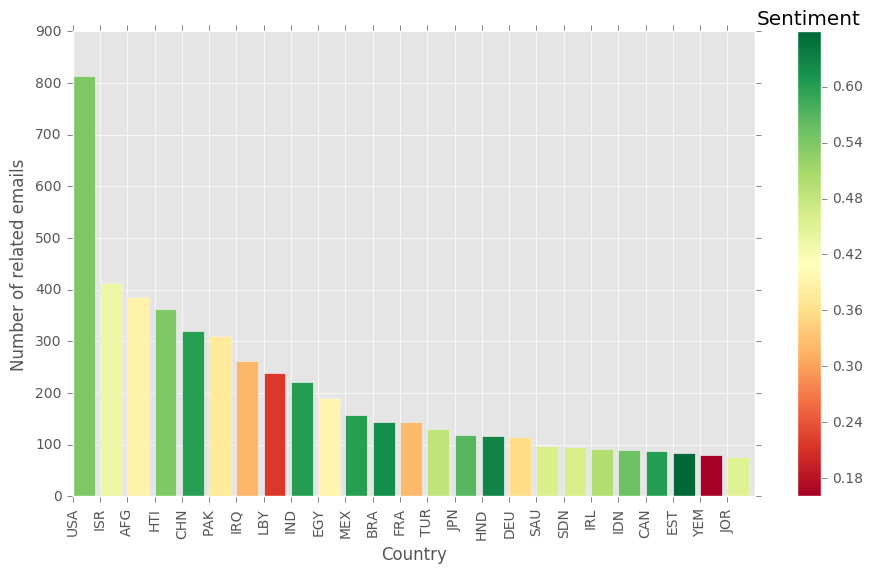

In [28]:
#For the clarity of the plot, we decided to output the polarity scores of only the top 25 mentionned country.
dataToPlot = finalDataFrame.iloc[:25,:]

plt.figure(figsize=(11,6))
# Sentiments color: red to green
z = np.array(dataToPlot.SIA)
min=float(z.min())
max=float(z.max())
colorsIntensity = (z-min)/(max-min)
colors = cm.RdYlGn(colorsIntensity)
plot = plt.scatter(z, z, c=z, cmap="RdYlGn")
plt.clf()
clb = plt.colorbar(plot)
clb.ax.set_title("Sentiment")

plt.bar(range(25),dataToPlot.Number,tick_label=dataToPlot.index, color=colors)
plt.xticks(rotation=90, ha="center")
plt.xlabel('Country')
plt.ylabel('Number of related emails')
plt.show()

# 3. Topic modelling:

In this part, we will use the gensim library to run topic modelling over the emails corpus. In fact, LDA assumes documents are produced from a number of different topics. Those topics then generate words based on their probability distribution. Hence, given this assumption of how documents are created, LDA tries to figure out what topics would create those documents in the first place.

In [29]:
list_of_emails=list(emailsCleaned.Text)

In [30]:
def build_ldaModels (list_of_mails, range_of_num_topics, fname_prefix):
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # Create tokinizer of class RegexpTokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words useless words and numbers list
    en_stop = set(stopwords.words('english')).union(set(['http','will','com','us','pm','ok','www','would','b5','b6','b1','00'])).union(set([str(i) for i in (range(0,1000))])) 
    # Initiate the resulting preprocessed list of emails
    emails_preprocessed=list([])
    for email in list_of_emails:
        # Lowercase email
        email = email.lower()
        # Tokenize email
        email_tokens = tokenizer.tokenize(email)
        # Remove stopwords
        email_tokens_stopped= [word for word in email_tokens if (not (word in en_stop) and len(word)>1)]
        # Stemming the resulting mail
        email_tokens_stopped_stemmed= [p_stemmer.stem(word) for word in email_tokens_stopped]
        # Add the preprocessed mail to the the list of preprocessed emails
        emails_preprocessed.append(email_tokens_stopped_stemmed)
    # Create a dictionary form the list of preprocessed emails: it is a list of the 
    #mapping between normalized words and their integer ids
    dictionary = corpora.Dictionary(emails_preprocessed)
    # Create a corpus with the different emails and using the dictionary we built previously
    corpus = [dictionary.doc2bow(email) for email in emails_preprocessed]
    # Buil an Lda models for every number of topics in the range argument
    for num_topics in range_of_num_topics:
        ldamodel = LdaModel(corpus, num_topics= num_topics, id2word = dictionary)
        # Save the model
        ldamodel.save(fname_prefix+"{}".format(num_topics))

In [31]:
# This function Loads all model already built
def Load_ldaModels (range_of_num_topics, fname_prefix):
    list_of_models=list([])
    for topic_number in range_of_num_topics:
        model= LdaModel.load(fname_prefix+"{}".format(topic_number))
        list_of_models.append(model)
    return list_of_models

In [32]:
# This function returns a list of lists of strings given a list of models, 
#Every Model is represented by a list of its topics and each topic is represented with a string of its most probable words).
def get_topics_from_models(list_of_LdaModels,num_words):
    list_of_models_topics=list([])
    for model in (list_of_LdaModels):
        list_of_topics=list([])
        topics=model.show_topics(num_topics=-1,num_words=num_words,formatted=False)
        for topic in range(0,len(topics)):
            topic_name=''
            for word,prob in topics[topic][1]:
                topic_name=topic_name +" "+ str(word)
            list_of_topics.append(topic_name)
        list_of_models_topics.append(list_of_topics)
    return list_of_models_topics

In [33]:
def print_topics_from_list_of_models_topics(list_of_models_topics):
    for model_topics in list_of_models_topics:
        print("\n****************************************** Num Topics = {} **********************************************************".format (len(model_topics)))
        i=-1
        for topic in model_topics:
            i+=1
            print ("Topic {} : ".format(i+1)+topic)

In [34]:
# Define the number of topics to build Lda models for.
range_num_topics=list(5*np.array(range(1,11)))
#range_num_topics=[5,10,15,20,30,40,50]

In [40]:
# Build multiple lda Models with different number of topics and save them.
build_ldaModels (list_of_emails, range_of_num_topics=range_num_topics,fname_prefix='LDA_topic_num_')

In [41]:
# Load these Models
list_test= Load_ldaModels(range_of_num_topics=range_num_topics,fname_prefix='LDA_topic_num_')
# Compute the topics for each model
list_of_models_topics=get_topics_from_models(list_of_LdaModels=list_test,num_words=15)
# Print all topics for different models
print_topics_from_list_of_models_topics(list_of_models_topics)


****************************************** Num Topics = 5 **********************************************************
Topic 1 :  secretari meet offic call time state depart know work want talk go get need tomorrow
Topic 2 :  state one govern obama right say clinton american year presid new peopl countri like world
Topic 3 :  state call email gov 2010 get work also senat know say thank see secretari pleas
Topic 4 :  presid new american republican senat obama hous parti democrat public one state time support like
Topic 5 :  state govern israel presid work develop haiti nation unit need peopl issu intern new countri

****************************************** Num Topics = 10 **********************************************************
Topic 1 :  govern public uk guardian parti state call new co year polic power polit one report
Topic 2 :  call talk state work time 2010 get also know like see go countri want say
Topic 3 :  israel isra palestinian state call arab netanyahu peac minist talk pr

It is hard to compare these models with this this representation, this is why we will implement a function that visualise the most commun words for each topic to help us draw a conclusion about the most suitable number of topics.

In [58]:
def show_results (ldaModel,num_topics):
    num_top_words = 15
    fontsize_base = 170 # font size for word 
    map_word_to_prob=ldaModel.show_topics(num_topics=num_topics,num_words=num_top_words,formatted=False)
    fig, axes = plt.subplots(nrows=math.ceil(num_topics/5), ncols=5, figsize=(num_top_words, num_topics),squeeze=False)
    for topicId in range(0,num_topics):
        fragment=axes[int(topicId/5)][topicId%5]
        plt.sca(fragment)
        plt.ylim(0, num_top_words + 0.75)  # stretch the y-axis to accommodate the words
        plt.xticks([])  # remove x-axis markings ('ticks')
        plt.yticks([]) # remove y-axis markings ('ticks')
        plt.title('Topic {}'.format(topicId+1),color='black',fontsize=20,fontweight='bold')
        topic_map=map_word_to_prob[topicId][1]
        total_prob=0
        for (word, prob) in topic_map: total_prob=total_prob+prob
        for i,(word, prob) in list(enumerate(topic_map)):
            prop= prob/total_prob
            color=''
            alpha=0
            if (prop>0.1): 
                colour='red'
                temp = prop*3+0.5
                if (temp<1):
                    alpha = temp
                else:
                    alpha=1
            elif (prop>0.05 and prop<=0.1):
                colour= 'blue'
                alpha=prop*10
            else: 
                colour='green'
                alpha=prop*20
            final_fontsize = fontsize_base*prop+2
            if (final_fontsize>30):
                final_fontsize = 30
            plt.text(0.1, num_top_words-i-0.75, word, fontsize=final_fontsize,color=colour,alpha=alpha)
    plt.tight_layout()

Let's first compare 10 topics and 5 topics:

In [59]:
five_topics_model= LdaModel.load('LDA_topic_num_'+"{}".format(5))

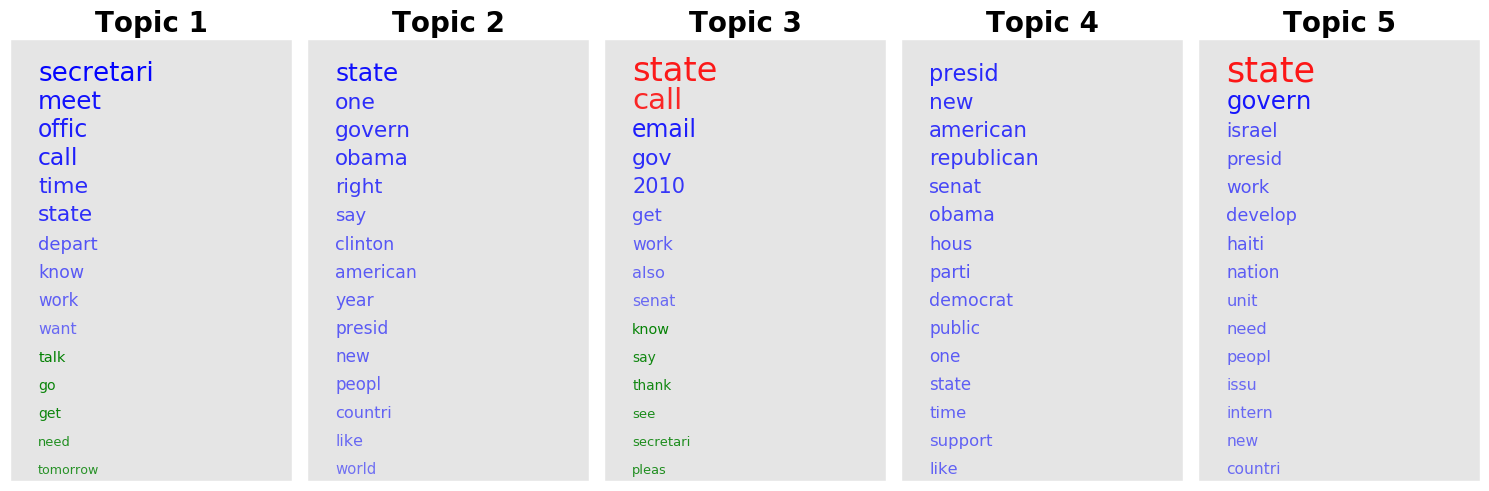

In [60]:
show_results(five_topics_model,5)

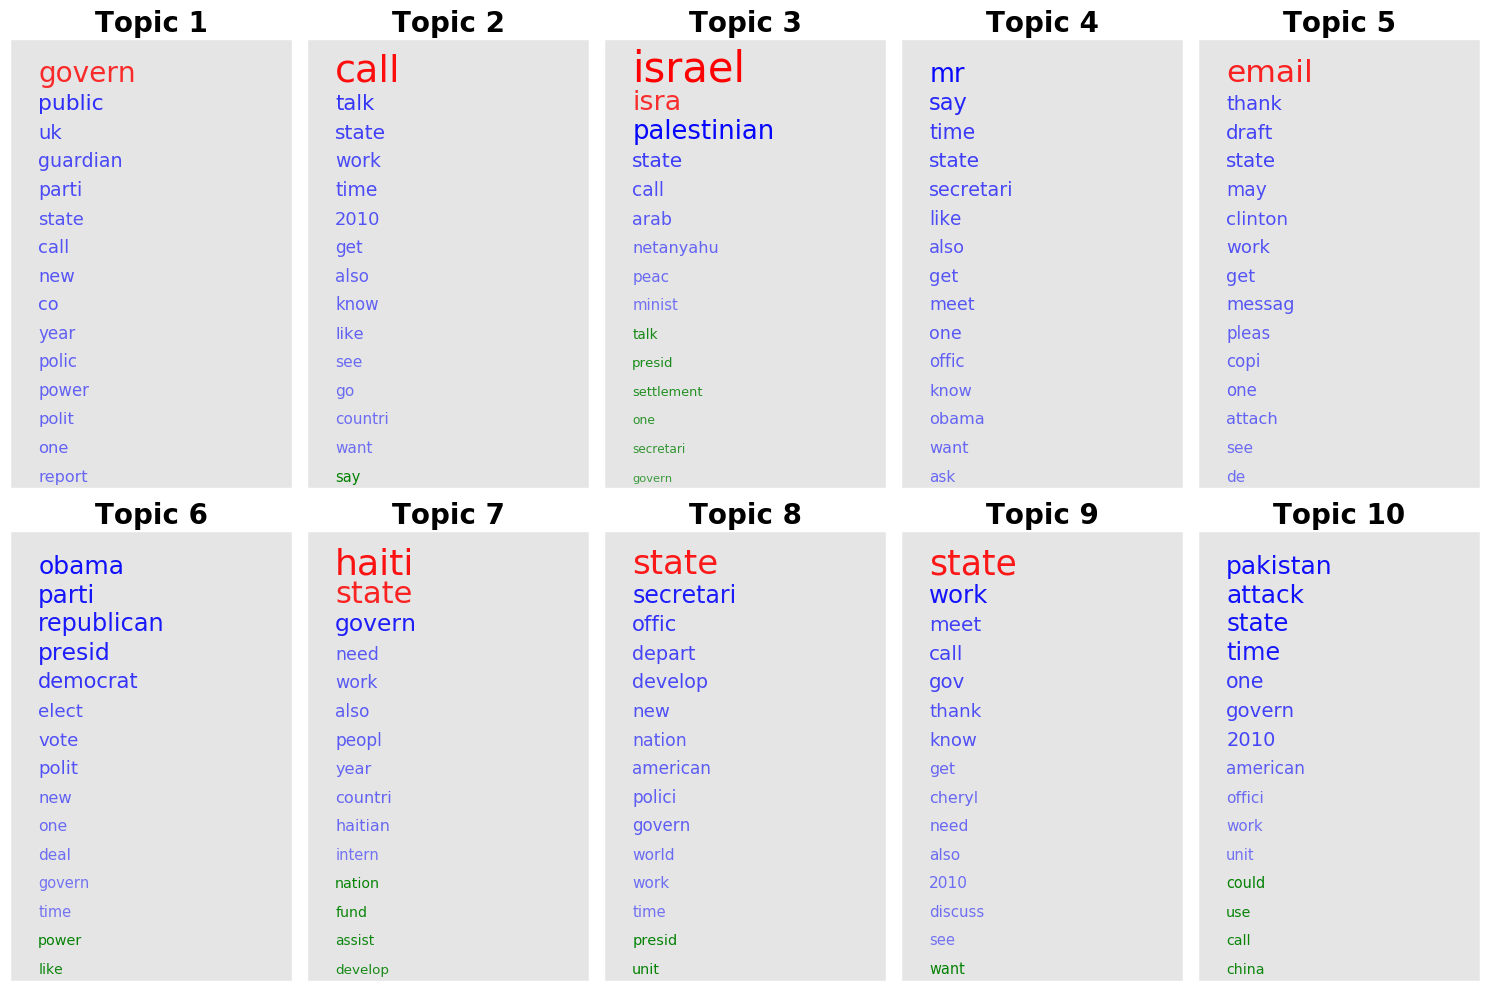

In [61]:
dix_topics_model= LdaModel.load('LDA_topic_num_'+"{}".format(10))
show_results(dix_topics_model,10)

We can see that 5 topics model merge some topics together which make the topic unprecise. For example, topic 4 merges israelian settlement topic with the american people's security and work. This problem is solved in 10 topics model. In fact, the israelien settlement topic is considered as a topic on its own and new keywords related to this topic were found (e.g. Palestinian, peace...). In addition some interesting Topics were found. For example, topic 9 related to the millitary relations of US with Pakistan and afghanistan.  However, some topic remain wide and unclear. For instance, topic 8 is related to the US elections and to UK. So let's figure out whether this problem is solved when we run a model with 20 Topics.


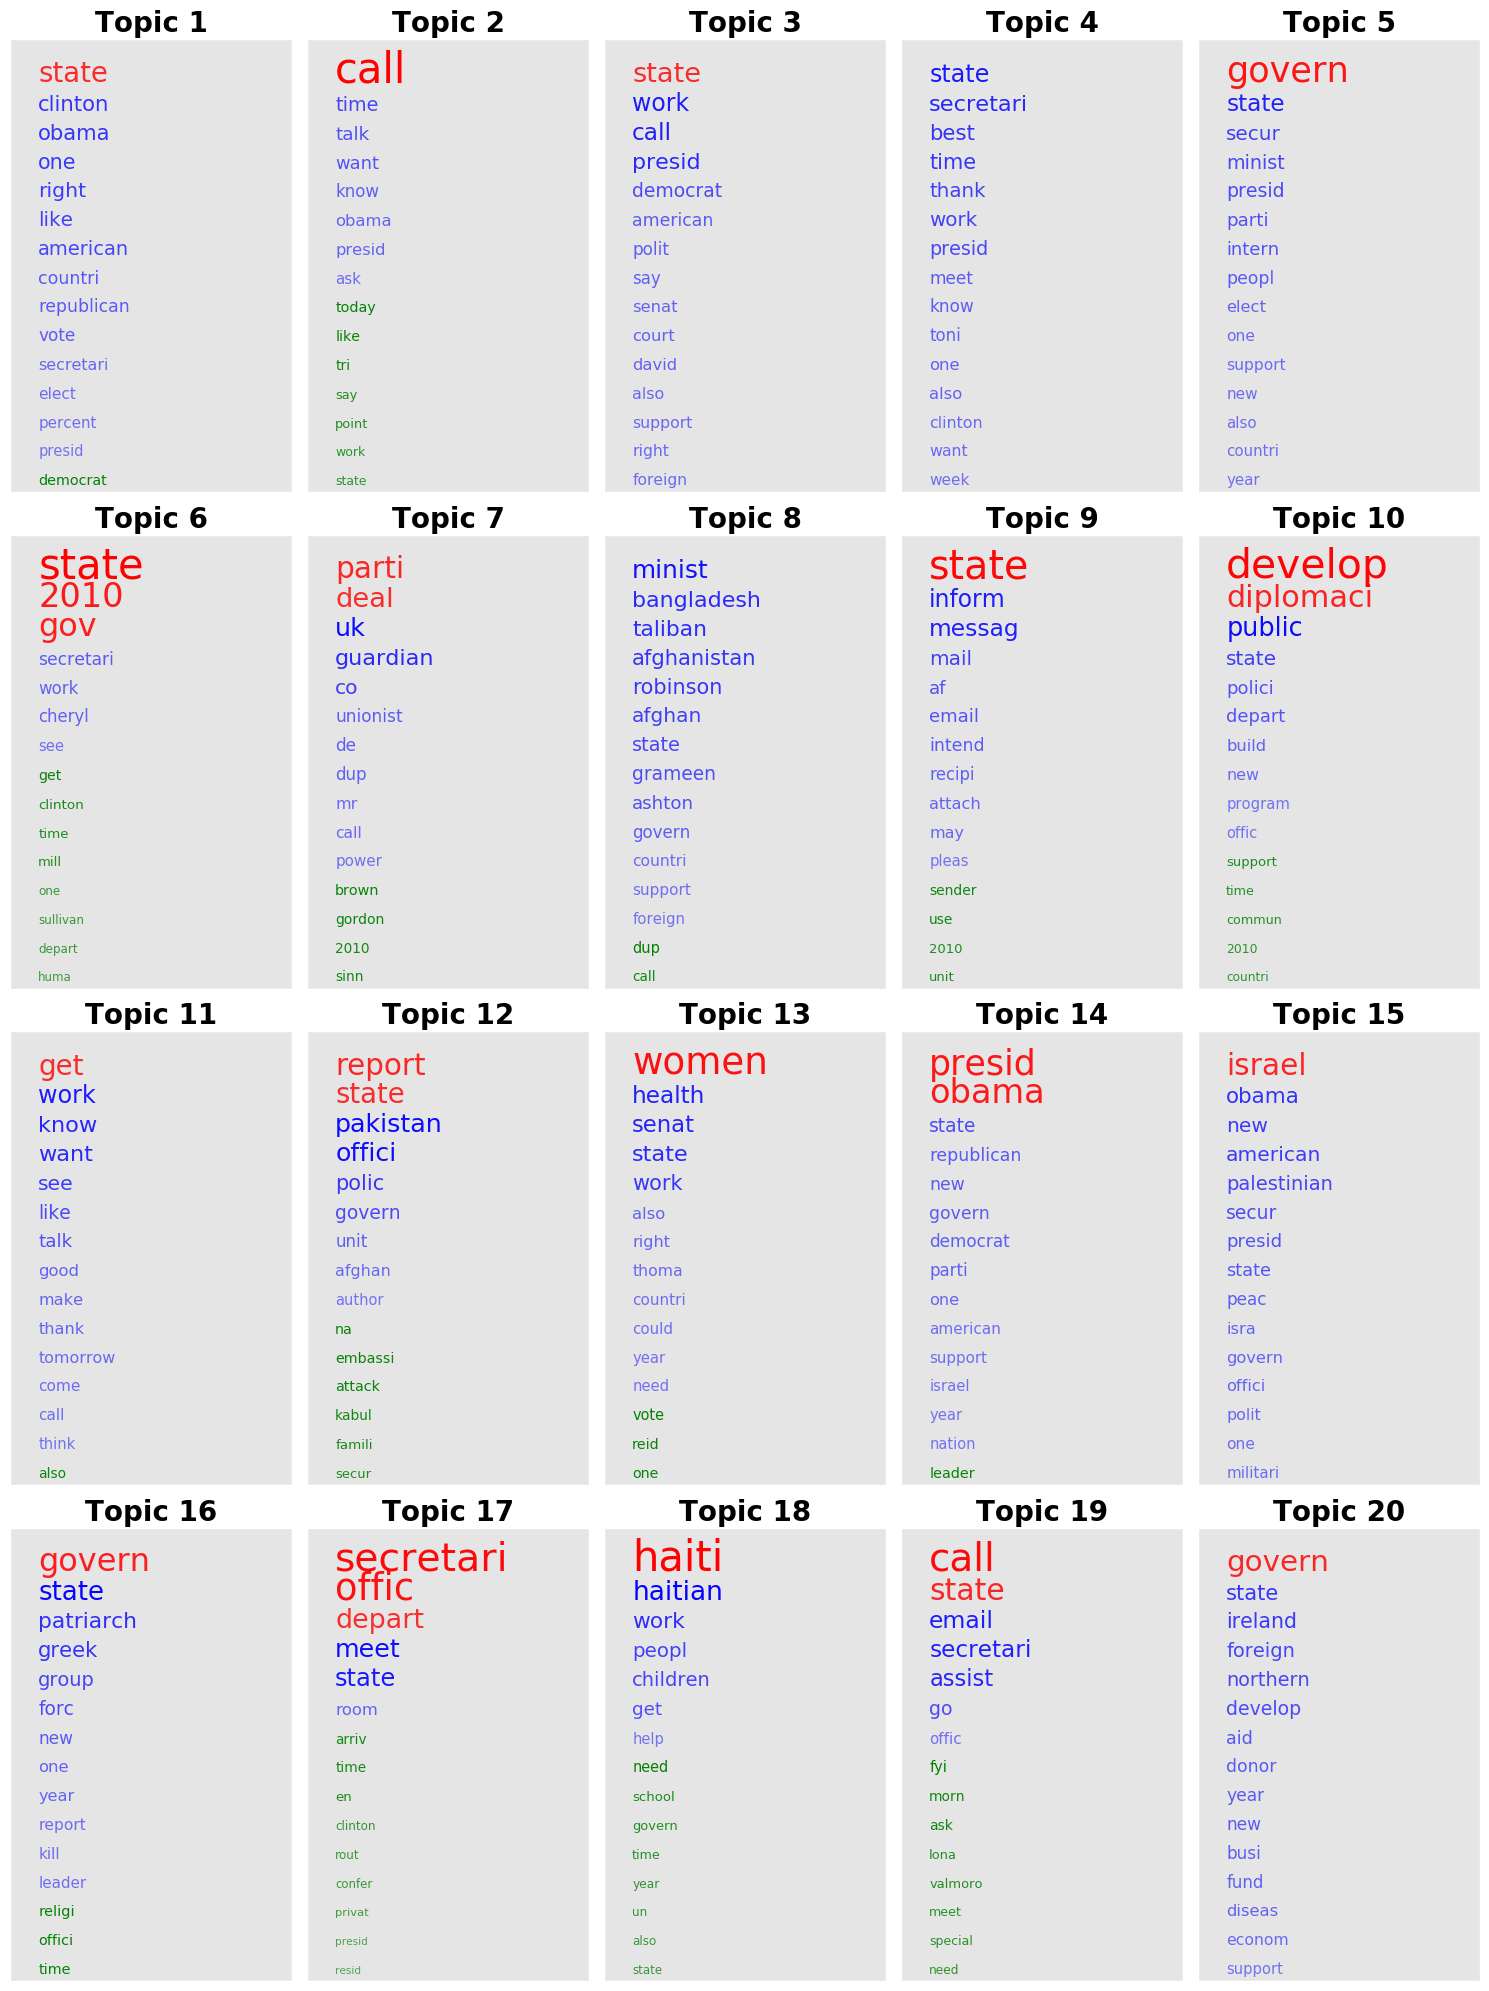

In [62]:
twenty_topics_model= LdaModel.load('LDA_topic_num_'+"{}".format(20))
show_results(twenty_topics_model,20)

More interesting topics are found. For example, The political relations with muslim arabic countries (Topic 16). However some topics contain the same ideas. For example, topic 17 and 10 have strong keyword Haiti which may reflect the strength of Haiti – US bilateral relations. Another problem is that more topics are wide and don't reflect a precise idea which can mean that this number of topics is enaugh to cover everything and further increase may lead to more uselees topics. So let's figure out with a model of 30 topics.

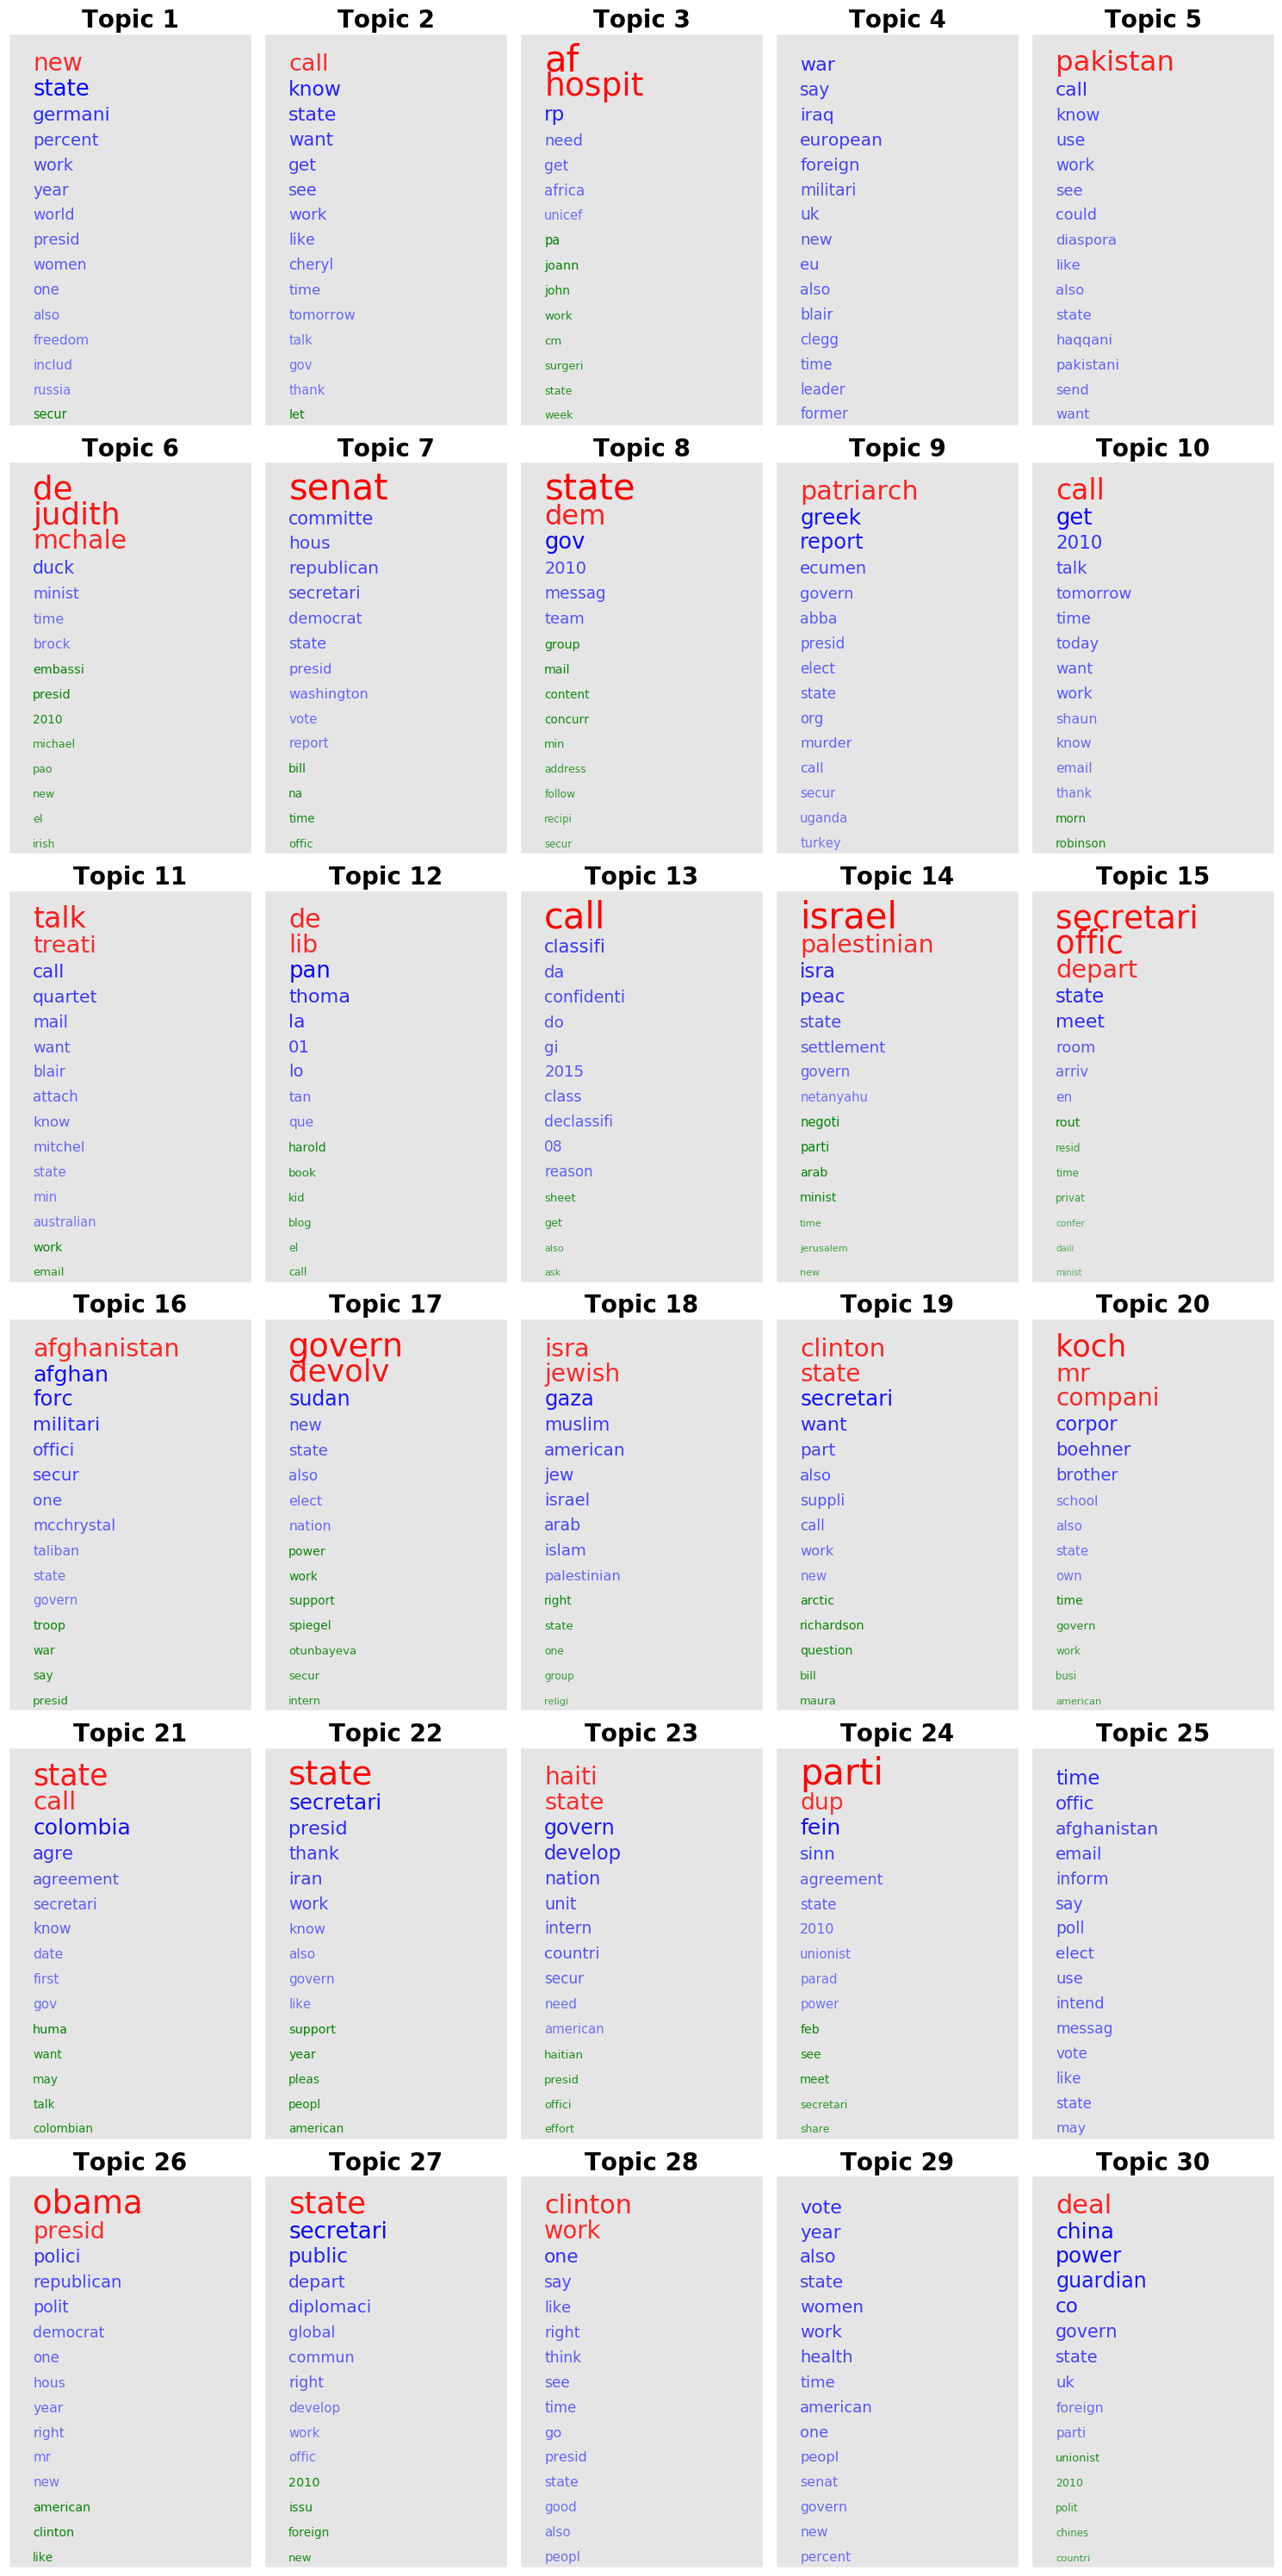

In [63]:
thirty_topics_model= LdaModel.load('LDA_topic_num_'+"{}".format(30))
show_results(thirty_topics_model,30)

We were wrong. In fact, more topics become clearer with relevant keywords as nettanyahu for Israel, attack, taliban, kill, nuclear for Pakistan. Some new topics emerged as Northern Ireland, England, Women health, as well as new persons like John Boehner and Catherine Ashton. However, some topics remain unclear as the set of words used doesn't seem to have relations. Let's try with 50 Topics.

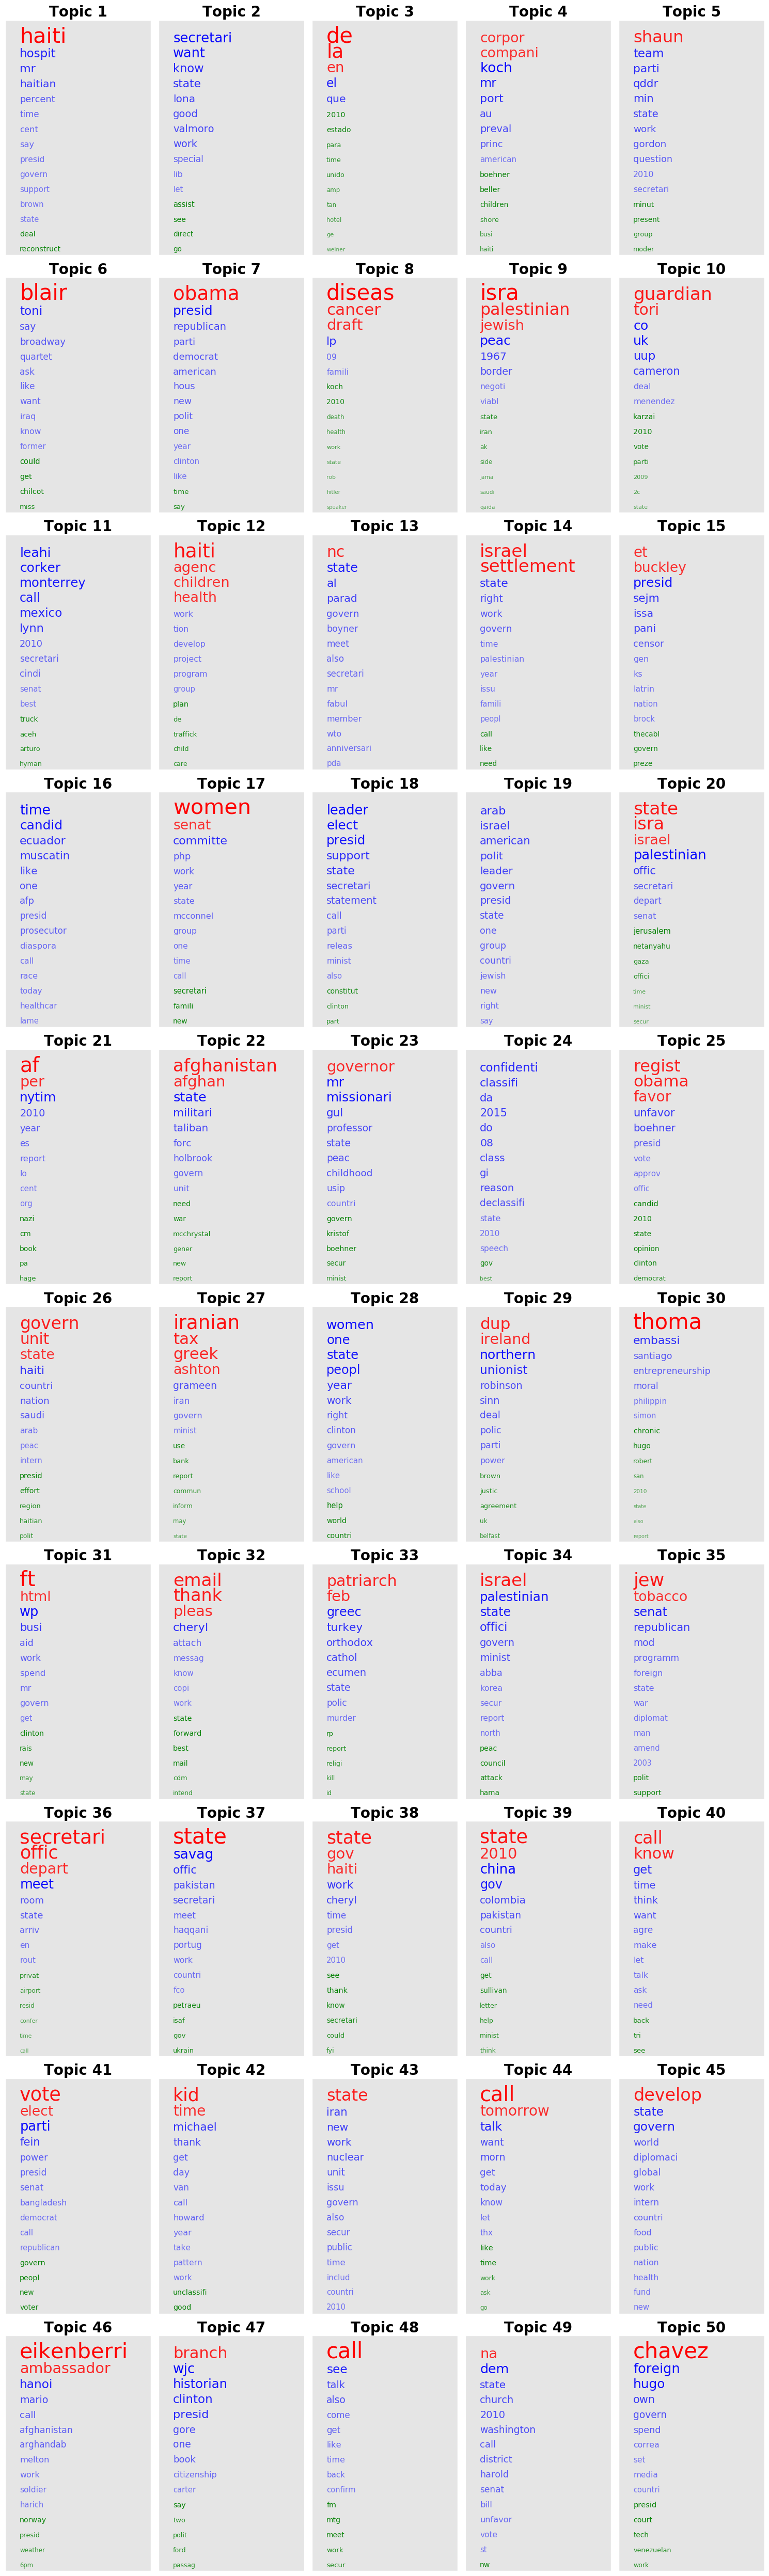

In [64]:
fifty_topics_model= LdaModel.load('LDA_topic_num_'+"{}".format(50))
show_results(fifty_topics_model,50)

Now, Topics are more clear and different words within a topic are more related. For example, we find 'earthquake' related to Haiti topic, 'jewish', 'jerusalem' related to Palestinian/Isrealian conflict, 'Davis Cameron' and 'James Gordon Brown' to UK. In addition, new topics emerged. For instance, German wall and Berlin history (Topic 20), Spain situation in the EU (Topic 16), Iran and nuclear weapons (Topic 10).
So to conclude, 50 Topics is a suitable number to see in clear different topics present in the corpus.

# 4. Bonus:

In [99]:
import networkx as nx
import community
from collections import defaultdict
from nltk.probability import FreqDist

In [96]:
# Helper function that convert its argument to a string
def toString(x):
    return str(x)

In [97]:
# Helper function that given the name of a person returns its unique id
def id_for_person(person_name):
    return persons_Id[persons_Id['Person']==person_name].index.tolist()[0]
# Helper function that given an id returns the name of the person with the argument id
def person_from_id(id):
    return persons_Id.Person[id]

In [90]:
# Compute a data frame with only sender and receiver names
data = emails
data['MetadataTo']=data['MetadataTo'].apply(toString)
data['MetadataFrom']=data['MetadataFrom'].apply(toString)
sender_recipient_data=data.ix[:,2:4]
sender_recipient_data.columns=['Receiver','Sender']
#sender_recipient_data['Receiver']=sender_recipient_data['Receiver'].apply(toString)
#sender_recipient_data['Sender']=sender_recipient_data['Sender'].apply(toString)
# Compute a list of all distinct people
senders= data.ix[:,3]
recipient= data.ix[:,2]
all_persons= set(pd.concat([senders,recipient]).dropna())
persons_Id=pd.DataFrame((list(all_persons)),columns=['Person'])
persons_Id['Person']= persons_Id['Person'].apply(toString)
# Discard entries containing nans (either for sender or receiver) and replace every person with a distinct Id
sender_recipient_data=sender_recipient_data[(sender_recipient_data['Receiver']!='nan')& (sender_recipient_data['Sender']!='nan')]
sender_recipient_data['Receiver']=sender_recipient_data['Receiver'].apply(id_for_person)
sender_recipient_data['Sender']=sender_recipient_data['Sender'].apply(id_for_person)
sender_recipient_data.head()

,Receiver,Sender
Id,,
1,232,71
3,91,141
4,232,141
5,166,232
6,416,232


In [91]:
# Build a graph
G=nx.Graph()
# Add all nodes from the person_Id list
G.add_nodes_from(persons_Id.index)
edges=[]
# Add an edge for every mail sent/received by 2 nodes (persons)
for index in sender_recipient_data.index:
    sender=sender_recipient_data.ix[index]['Sender']
    receiver=sender_recipient_data.ix[index]['Receiver']
    edges.append((sender,receiver))
G.add_edges_from(edges)

In [100]:
# Compute the partition of the graph nodes which maximises the modularity 
#using the Louvain heuristices
partition = community.best_partition(G)

AttributeError: module 'community' has no attribute 'best_partition'

In [101]:
# Draw the graph
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
for com in set(partition.values()) :
    count += 1.
    list_nodes = [nodes for nodes in partition.keys()
                                 if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 10,
                                node_color = str(count / size))
nx.draw_networkx_edges(G,pos, alpha=0.5)
plt.show()

NameError: name 'partition' is not defined

In [102]:
# Let's now compute the nodes in different communities.
communities = defaultdict(list)
for node,community_index in partition.items():
    communities[community_index].append(node)
    
# Let's drop communities with less than 2 nodes
new_communities = dict(communities)
for community_index, list_of_nodes in communities.items():
    if (len(list_of_nodes)<2): del new_communities[community_index]
print ("We are interested in only {} communities.".format(len (new_communities)))

NameError: name 'partition' is not defined

In [103]:
# This function returns top fiveteen words used in emails sent by or received from the argument list of nodes
def top_words_from_nodes (list_of_nodes,num_words,min_number_of_words):
    # Convert the list of nodes to a DFrame of persons
    concerned_persons=[person_from_id(id) for id in list_of_nodes]
    concerned_persons= pd.DataFrame(concerned_persons)
    concerned_persons.columns=['Person']
    # Merge with the whole dataset to find the email exchanged in this community
    emails_receivers=data.merge(concerned_persons,how='inner',left_on='MetadataTo',right_on='Person')['RawText'].apply(cleanMessage)
    emails_senders=data.merge(concerned_persons,how='inner',left_on='MetadataFrom',right_on='Person')['RawText'].apply(cleanMessage)
    emails=pd.concat([emails_receivers,emails_senders])
    # Process the emails (As we did in previous parts)
    processed_emails=process_emails(emails)
    # flatten the list of lists of words to have only one list of words to extract from
    #the top use words
    flattened_email=list([])
    for email in list(processed_emails):
        flattened_email.extend(email)
    # Record the number of times each word occured
    fdist = FreqDist(flattened_email)
    # Return top used words
    top_words = fdist.most_common(num_words)
    return top_words

In [104]:
# This function displays in a nice way the top used words for each community
def show_words_for_communities (communities,num_words):
    num_topics=len(new_communities)
    fontsize_base = 170
    fig, axes = plt.subplots(nrows=math.ceil(num_topics/5), ncols=5, figsize=(num_words, num_topics),squeeze=False)
    i=-1
    for index, nodes in communities.items():
        top_words=top_words_from_nodes(nodes,num_words)
        # We don't display communities that exchanged less than the required number of 
        #top words
        if len(top_words)<num_words: continue
        i+=1
        index=i
        fragment=axes[int(index/5)][index%5]
        plt.sca(fragment)
        plt.ylim(0, num_words + 0.75)  # stretch the y-axis to accommodate the words
        plt.xticks([])  # remove x-axis markings ('ticks')
        plt.yticks([]) # remove y-axis markings ('ticks')
        plt.title('Community {}'.format(index+1),color='black',fontsize=20,fontweight='bold')
        total_freq=0
        for word,freq in top_words : total_freq+=freq
        for k,(word,freq) in enumerate(top_words):
            prop= freq/total_freq
            color=''
            alpha=0
            if (prop>0.1): 
                colour='red'
                alpha=min(prop*3+0.5,1)
            elif (prop>0.05 and prop<=0.1):
                colour= 'blue'
                alpha=prop*10
            else: 
                colour='green'
                alpha=prop*20
            plt.text(0.1, num_words-k-0.75, word, fontsize=min(fontsize_base*prop+2,30),color=colour,alpha=alpha)
    plt.tight_layout()

In [105]:
show_words_for_communities (new_communities,15)

NameError: name 'new_communities' is not defined

Not surprisingly, we can see that some topics we found from our LDA models built in the previous section are present in the top words of some community: 
- 'Obama health care system and wemen security' (community 22) 
- 'The northern Ireland' (Community 13). 
- 'The nuclear weapons issues'(community 27) ...

The more interesting thing is that new topics can be spotted: 
- 'Mongolia and its new president (2009)' (community 23)
- 'Cuba as part of the list of states sponsors of terrorism' (community 6)
- 'Siri Lanka LTTE conflict' (community 29)...

However, some topics we labeled from the Lda model output are not present in any community (e.g. Israelian/Palestinian conflict).

To conclude, both methods allowed us find some interesting topics. Which leads to an obvious question: 
> **What if we combine the two methods: Find communities and build an LDA models for each community corpus ?**